In [6]:

import numpy as np
from numba import jit

def randint_numpy(n):
    return np.random.randint(0, 10000, n)

@jit
def randint_numpy_jit(n):
    return np.random.randint(0, 10000, n)

%timeit randint_numpy(5)
%timeit randint_numpy_jit(5)


3.56 µs ± 225 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.11 µs ± 55.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [1]:
import hashlib
import pandas as pd
import networkx as nx
import functools
import operator

In [2]:
from pyparsing import Word, delimitedList, Optional, \
    Group, alphas, alphanums, Forward, oneOf, quotedString, \
    infixNotation, opAssoc, ParseResults, \
    ZeroOrMore, restOfLine, CaselessKeyword, pyparsing_common as ppc
import matplotlib.pyplot as plt
import copy
%matplotlib inline
# define SQL tokens
selectStmt = Forward()
SELECT, FROM, WHERE, AND, OR, IN, IS, NOT, NULL, COUNT, AVG, MIN, MAX, SUM, AS = map(CaselessKeyword, 
    "select from where and or in is not null count avg min max sum as".split())
NOT_NULL = NOT + NULL

ident          = Word( alphas, alphanums + "_$" ).setName("identifier")
alias          = delimitedList(ident, ".", combine=True).setName("alias")
alias.addParseAction(ppc.upcaseTokens)
columnName     = delimitedList(ident, ".", combine=True).setName("column name")
columnName.addParseAction(ppc.upcaseTokens)
columnNameList = Group( delimitedList(columnName))
tableName      = delimitedList(ident, ".", combine=True).setName("table name")
tableName.addParseAction(ppc.upcaseTokens)
tableNameRalias= Group(
    (tableName("table") + AS + alias("alias")) |
    (tableName("table"))
    )

tableNameList  = Group(delimitedList(tableNameRalias))

binop = oneOf("= != < > >= <= eq ne lt le gt ge", caseless=True)
realNum = ppc.real()
intNum = ppc.signed_integer()

columnRval = realNum | intNum | quotedString | columnName # need to add support for alg expressions
val = realNum | intNum | quotedString
columnRstar = '*' | columnName # need to add support for alg expressions
EquiJoin =     (columnName('col1') + '=' + columnName ('col2'))
equalityPredicate = columnName('col1') + '=' + columnRval ('val')
Predicates =     Group(( columnName('col1') + binop + columnRval ) |
    ( columnName('col1') + IN + Group("(" + delimitedList( columnRval ) + ")" )) |
    ( columnName('col1') + IN + Group("(" + selectStmt + ")" )) |
    ( columnName + IS + (NULL | NOT_NULL)))

whereCondition = Group(
    EquiJoin ('equijoin') |
    equalityPredicate ('equalitypredicate') |
    Predicates ('otherPredicates')
    )

whereCondition_sketch = Group(
    EquiJoin ('equijoin') |
    equalityPredicate ('equalitypredicate') 
    )

Aggregates = Group(
     ((COUNT|AVG|MIN|MAX|SUM)("operator") + (Group ("("+columnName+")"))("operand") ) |
     (COUNT("operator") + Group("("+"*"+")")("operand"))
    )

AggregateExpression = delimitedList(Aggregates)

whereExpression_predicates = infixNotation(whereCondition_sketch,
    [
        (AND, 2, opAssoc.LEFT),
    ])

whereExpression = infixNotation(whereCondition,
    [
        (NOT, 1, opAssoc.RIGHT),
        (AND, 2, opAssoc.LEFT),
        (OR, 2, opAssoc.LEFT),
    ])

# define the grammar
selectStmt <<= (SELECT + ((AggregateExpression)("aggregates") | ('*' | columnNameList)("columns")) +
                FROM + tableNameList( "tables" ) +
                WHERE +(whereExpression_predicates)("sketch_predicates")+ Optional((whereExpression)("predicates")))

simpleSQL = selectStmt

# define Oracle comment format, and ignore them
oracleSqlComment = "--" + restOfLine
simpleSQL.ignore( oracleSqlComment )

if __name__ == "__main__":
    simpleSQL.runTests("""\
        # multiple tables
        SELECT * from XYZZY, ABC WHERE 
        # dotted table name
        select * from SYS.XYZZY
        Select A from Sys.dual
        Select A,B,C from Sys.dual
        Select A, B, C from Sys.dual, Table2
        # FAIL - invalid SELECT keyword
        Xelect A, B, C from Sys.dual
        # FAIL - invalid FROM keyword
        Select A, B, C frox Sys.dual
        # FAIL - incomplete statement
        SelectR
        # FAIL - incomplete statement
        Select * from
        # FAIL - invalid column
        Select &&& frox Sys.dual
        # where clause
        Select A from Sys.dual where a in ('RED','GREEN','BLUE')
        # compound where clause
        Select A from Sys.dual where a in ('RED','GREEN','BLUE') and b in (10,20,30)
        # where clause with comparison operator
        Select A,b from table1,table2 where table1.id eq table2.id
        """)


# multiple tables
SELECT * from XYZZY, ABC WHERE
                              ^
FAIL: Expected {"and" term | Group:({{column name "=" column name} | {column name "=" {real number | signed integer | quotedString using single or double quotes | column name}}}) | {Suppress:("(") Forward: ... Suppress:(")")}} (at char 30), (line:1, col:31)

# dotted table name
select * from SYS.XYZZY
                       ^
FAIL: Expected "where" (at char 23), (line:1, col:24)


Select A from Sys.dual
                      ^
FAIL: Expected "where" (at char 22), (line:1, col:23)


Select A,B,C from Sys.dual
                          ^
FAIL: Expected "where" (at char 26), (line:1, col:27)


Select A, B, C from Sys.dual, Table2
                                    ^
FAIL: Expected "where" (at char 36), (line:1, col:37)

# FAIL - invalid SELECT keyword
Xelect A, B, C from Sys.dual
^
FAIL: Expected "select" (at char 0), (line:1, col:1)

# FAIL - invalid FROM keyword
Select A, B, C frox Sys.dual
               

In [3]:

def CreateJoinGraph(queryString):
    ParseResults = simpleSQL.parseString(queryString,parseAll=True)
    if "columns" in ParseResults:
        assert(0) # cannot return result using AQP
        
    aggregate_list = []
    table_dict = {}
    equi_joins_set = set([])
    predicates_set = set([])
    
    for aggregate in ParseResults['aggregates']:
        aggregate_list.append(aggregate)
        
    for table in ParseResults['tables']:
        if 'alias' in table:
            name = table['alias']
        else:
            name = table['table']
        if name in table_dict:
            assert(0) # cannot have duplicate names for tables
        else:
            table_dict[name] = table['table']
            
    for predicate in ParseResults['sketch_predicates']:
        if predicate == 'and':
            pass
        elif type(predicate) == type(ParseResults):
            if 'equijoin' in predicate:
                alias,column = predicate['col1'].split('.') # throws error if malformed column
                alias2,column2 = predicate['col2'].split('.')
                assert((alias in table_dict) and
                       (alias2 in table_dict) and
                       (alias != alias2))
                equi_joins_set.add( (alias,column, alias2,column2) )
            elif 'equalitypredicate' in predicate:
                alias,column = predicate['col1'].split('.')
                assert(alias in table_dict)
                value = predicate['val']
                predicates_set.add( (alias,column,value) )
            else:
                assert(0) # unexpected value in sketch_predicates
        else:
            assert(0) # unexpected value in sketch_predicates
    
    G = nx.MultiGraph()
    for ident, table_name in table_dict.items():
        G.add_node(ident, table_name = table_name)
    for equi_join in equi_joins_set:
        alias, col, alias2, col2 = equi_join
        G.add_edge(alias,alias2,equijoin = {alias:col, alias2:col2})
        #G[alias][alias2]['equijoin'] = {alias:col, alias2:col2}
    if predicates_set:
        G.add_node('__imaginary_table__')
        for predicate in predicates_set:
            alias, col, val = predicate
            G.add_edge('__imaginary_table__',alias,predicate = {alias : col, '__val__' : str(val).strip("\"\'")})
            #G['__imaginary_table__'][alias]['predicate'] = {alias : col, '__val__' : str(val)}
    return G

def drawGraph ( G):
    fig, ax = plt.subplots()
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])

    pos = nx.spring_layout(G)
    pos2 = copy.deepcopy(pos) 
    for p in pos2:  # raise text positions
        pos2[p][1] += 0.5


    nx.draw_networkx_edge_labels(G,pos = pos2,ax = ax)
    nx.draw(G, pos = pos,ax = ax,width = 3, font_size=16, with_labels=True)



T12
TABLE2
{'equijoin': {'T12': 'ID', 'TABLE2': 'ID'}}
{'equijoin': {'T12': 'NAME', 'TABLE2': 'NAME'}}
__imaginary_table__
{'predicate': {'T12': 'WAGE', '__val__': '4000'}}
TABLE2
T12
{'equijoin': {'T12': 'ID', 'TABLE2': 'ID'}}
{'equijoin': {'T12': 'NAME', 'TABLE2': 'NAME'}}
__imaginary_table__
T12
{'predicate': {'T12': 'WAGE', '__val__': '4000'}}


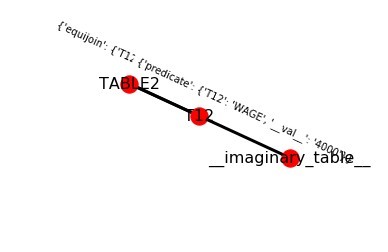

In [4]:
G = CreateJoinGraph("select COUNT(*), avg (T2.mm), max(T1.ss) FROM table1 as T12,table2 where T12.name = table2.name AND T12.id = table2.id AND T12.wage = 4000")

fig, ax = plt.subplots()
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])

pos = nx.spring_layout(G)
pos2 = copy.deepcopy(pos) 
for p in pos2:  # raise text positions
    pos2[p][1] += 0.5


nx.draw_networkx_edge_labels(G,pos = pos2,ax = ax)
nx.draw(G, pos = pos,ax = ax,width = 3, font_size=16, with_labels=True)

for node in G:
    print(node)
    for edge,e_dict in G[node].items():
        print(edge)        
        for e_id, e_attr in e_dict.items():
            print(e_attr)




In [5]:
import hashlib
import re, string 
pattern = re.compile('^[a-zA-Z][a-zA-Z0-9]*$')

print(hashlib.algorithms_available)
help(hashlib.sha1)

#hashlib.sha1(3)

def create_hash(value,seed):
    m = hashlib.md5(seed.encode('utf-8'))
    m.update(str(value).encode('utf-8'))
    return (int(m.hexdigest(),16)%2)*2 - 1

def signature__imaginary_table__(node, num_replicas):
    '''check for non-duplicate predicates and create signature of imaginary table'''
    signatures = [1]*num_replicas
    partial_seeds = [str(x) for x in range(num_replicas)]
    
    seen_alias_col = set([''])
    for edge, e_dict in node.items():
        for e_id, e_attr in e_dict.items():
            seed_str = '-'.join(e_attr['predicate'].keys())+'-'+'-'.join(e_attr['predicate'].values())
            full_seeds = [x + seed_str for x in partial_seeds]

            alias_col = ''
            for alias in e_attr['predicate']:
                if alias  != '__val__':
                    alias_col = alias+e_attr['predicate'][alias]
            if alias_col in seen_alias_col:
                assert(alias_col!='') # malformed edge attributes
                assert(0) # cannot have multiple equality predicate on same relation col         
            else:
                seen_alias_col.add(alias_col)
            signatures = [sig*create_hash(e_attr['predicate']['__val__'],seed) for sig,seed in zip(signatures,full_seeds)]
    return signatures
            
        
class dataFrameCursor():
    '''wrapper for dataframe to use same API as DictCursor for databases'''
    
    def __init__(self, dataframes, table_names ):
        self.tables = {}
        for df, name  in zip(dataframes,table_names):
            self.tables[name] = df
    
    def dictionary_iterator(self, table_name):
        for index, row in self.tables[table_name].iterrows():
            yield row
            
    def execute(self, sql, table):
        assert(sql=='''select * from ?''')
        self.next_table = table
        
    def fetchall(self): 
        return self.dictionary_iterator(self.next_table)

def create_hashs(G,num_replicas):
    partial_seeds = [str(x) for x in range(num_replicas)]
    signature_funcs = {}
    
    for node,n_attr in G.node.items():
        if node == '__imaginary_table__':
            pass # we do not construct dummy_table's signatures until runtime
        else:
            table_name = n_attr['table_name']
            assert (pattern.match(table_name)) # check if valid sql table name
            table_signature_funcs = {}
            for edge,e_dict in G[node].items():
                for e_id, e_attr in e_dict.items():
                    if 'equijoin' in e_attr:
                        column_name = e_attr['equijoin'][node]                    
                        seed_str = '-'.join(e_attr['equijoin'].keys())+'-'+'-'.join(e_attr['equijoin'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    elif 'predicate' in e_attr:
                        column_name = e_attr['predicate'][node]                    
                        seed_str = '-'.join(e_attr['predicate'].keys())+'-'+'-'.join(e_attr['predicate'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    else:
                        assert(0) # malformed attributes
                    if column_name in table_signature_funcs:
                        table_signature_funcs[column_name].append(hashFuncs)
                    else:
                        table_signature_funcs[column_name]= [hashFuncs]
            if table_name in signature_funcs:
                signature_funcs[table_name][node] = table_signature_funcs
            else:
                signature_funcs[table_name] = {node : table_signature_funcs}
    return signature_funcs

        
def create_signatures(G,DictCursor,num_replicas):
    signatures_dict = {}
    signature_funcs = {}
    partial_seeds = [str(x) for x in range(num_replicas)]
    initial_signatures = [1]*num_replicas
    
    for node,n_attr in G.node.items():
        if node == '__imaginary_table__':
            signatures_dict['__imaginary_table__'] = signature__imaginary_table__(G['__imaginary_table__'],num_replicas)
        else:
            table_name = n_attr['table_name']
            assert (pattern.match(table_name)) # check if valid sql table name
            table_signature_funcs = {}
            for edge,e_dict in G[node].items():
                for e_id, e_attr in e_dict.items():
                    if 'equijoin' in e_attr:
                        column_name = e_attr['equijoin'][node]                    
                        seed_str = '-'.join(e_attr['equijoin'].keys())+'-'+'-'.join(e_attr['equijoin'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    elif 'predicate' in e_attr:
                        column_name = e_attr['predicate'][node]                    
                        seed_str = '-'.join(e_attr['predicate'].keys())+'-'+'-'.join(e_attr['predicate'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    else:
                        assert(0) # malformed attributes
                    if column_name in table_signature_funcs:
                        table_signature_funcs[column_name].append(hashFuncs)
                    else:
                        table_signature_funcs[column_name]= [hashFuncs]
            if table_name in signature_funcs:
                signature_funcs[table_name][node] = table_signature_funcs
            else:
                signature_funcs[table_name] = {node : table_signature_funcs}
    
    for table in signature_funcs:
        sql='''select * from ?'''
        DictCursor.execute(sql, table)
        rows = DictCursor.fetchall()
        for alias in signature_funcs[table]:
            signatures_dict[alias] = [0]*num_replicas
        for dict_row in rows:
            for alias in signature_funcs[table]:
                signatures = initial_signatures
                for column in signature_funcs[table][alias]:
                    for hashfunctions in signature_funcs[table][alias][column]:
                        signatures = [sig*hashfunc(dict_row[column]) for sig,hashfunc in zip(signatures,hashfunctions) ]
                        
                signatures_dict[alias]=[sig+delta for sig,delta in zip(signatures_dict[alias],signatures)]
    return signatures_dict





        
                    


{'dsaWithSHA', 'MD4', 'shake_128', 'sha3_512', 'sha256', 'sha224', 'sha1', 'sha3_256', 'shake_256', 'MD5', 'DSA', 'md4', 'sha3_224', 'SHA512', 'SHA', 'blake2b', 'SHA224', 'SHA256', 'ripemd160', 'SHA1', 'dsaEncryption', 'SHA384', 'sha3_384', 'sha384', 'sha', 'whirlpool', 'DSA-SHA', 'md5', 'ecdsa-with-SHA1', 'blake2s', 'sha512', 'RIPEMD160'}
Help on built-in function openssl_sha1 in module _hashlib:

openssl_sha1(...)
    Returns a sha1 hash object; optionally initialized with a string



In [6]:
G = CreateJoinGraph("""
                    SELECT COUNT(*)
                    FROM table1 as T11,
                         table1 as T12,
                         table2,
                         table3
                    WHERE T12.id = table2.id AND T12.name = T11.name AND T11.id = table3.id
                          AND T12.wage = 32000 """)

names =['TABLE1', 'TABLE2', 'TABLE3']
df1 = pd.DataFrame([[1,'jorge',32000],
                   [2,'marco',100000],
                   [3,'aaron',32000],
                   [4,'sandeep',32000],
                   [5,'iro',32000]],columns = ['ID','NAME','WAGE'])

                   
df2 = pd.DataFrame([[1,'jorge','boxing'],
                   [2,'marco','bad movies'],
                   [2,'marco','pasta'],                    
                   [3,'aaron','boxing'],
                   [4,'sandeep','body building'],
                   [5,'iro','swimming']], columns = ['ID','NAME','INTERESTS'])
                   
df3 = pd.DataFrame([[1,'jorge',25],
                   [2,'marco',41],
                   [3,'aaron',24],
                   [4,'sandeep',31],
                   [5,'iro',25]], columns = ['ID','NAME','AGE'])
                   
                
Cursor = dataFrameCursor([df1,df2,df3],names)

num_replicas = 1000
sum([functools.reduce(operator.mul, signature_tuple,1 ) for signature_tuple in zip(*create_signatures(G,Cursor,num_replicas).values())])/num_replicas


5.026

In [29]:
from itertools import combinations, chain

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


def create_hashs_seed(G,num_replicas):
    partial_seeds = [str(x) for x in range(num_replicas)]
    signature_funcs = {}
    
    for node,n_attr in G.node.items():
        if node == '__imaginary_table__':
            pass # we do not construct dummy_table's signatures until runtime
        else:
            table_name = n_attr['table_name']
            assert (pattern.match(table_name)) # check if valid sql table name
            table_signature_funcs = {}
            for edge,e_dict in G[node].items():
                for e_id, e_attr in e_dict.items():
                    if 'equijoin' in e_attr:
                        column_name = e_attr['equijoin'][node]                    
                        seed_str = '-'.join(e_attr['equijoin'].keys())+'-'+'-'.join(e_attr['equijoin'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    elif 'predicate' in e_attr:
                        column_name = e_attr['predicate'][node]                    
                        seed_str = '-'.join(e_attr['predicate'].keys())+'-'+'-'.join(e_attr['predicate'].values())
                        full_seeds = [x + seed_str for x in partial_seeds]
                        hashFuncs = [lambda v,seed = seed: create_hash(v,seed) for seed in full_seeds]
                    else:
                        assert(0) # malformed attributes
                    if seed_str in table_signature_funcs:
                        assert(0) # should never be duplicate seeds
                    table_signature_funcs[seed_str] = (column_name,hashFuncs)
                    
            if table_name in signature_funcs:
                signature_funcs[table_name][node] = table_signature_funcs
            else:
                signature_funcs[table_name] = {node : table_signature_funcs}
    return signature_funcs

def create_power_set_signatures(G,DictCursor,num_duplicate,num_replicas):
    signatures_dict = {}
    initial_signatures = [1]*num_replicas
    
    signature_funcs = create_hashs_seed(G,num_replicas)

    
    for table in signature_funcs:
        sql='''select * from ?'''
        DictCursor.execute(sql, table)
        rows = DictCursor.fetchall()
        powersets = {}
        for alias in signature_funcs[table]:
            signatures_dict[alias] = {}
            powersets[alias] = list(powerset(signature_funcs[table][alias].keys()))
            for edge_tuple in powersets[alias]:
                signatures_dict[alias][frozenset(edge_tuple)] = [0]*num_replicas
        for dict_row in rows:
            for alias in signature_funcs[table]:
                for edge_tuple in powersets[alias]:
                    signatures = initial_signatures
                    for edge_seed in edge_tuple:
                        column, hashfunctions = signature_funcs[table][alias][edge_seed]
                        signatures = [sig*hashfunc(dict_row[column]) for sig,hashfunc in zip(signatures,hashfunctions) ]
                    signatures_dict[alias][frozenset(edge_tuple)]=[sig+delta for sig,delta in zip(signatures_dict[alias][frozenset(edge_tuple)],signatures)]
    return (signatures_dict,num_replicas)

def create_seeds(G):
    seeds_dict = {}
    
    for node,n_attr in G.node.items():
        if node == '__imaginary_table__':
            pass # we do not construct dummy_table's signatures until runtime
        else:
            seeds_dict[node] = set([])
            for edge,e_dict in G[node].items():
                for e_id, e_attr in e_dict.items():
                    if 'equijoin' in e_attr:
                        column_name = e_attr['equijoin'][node]                    
                        seed_str = '-'.join(e_attr['equijoin'].keys())+'-'+'-'.join(e_attr['equijoin'].values())
                    elif 'predicate' in e_attr:
                        column_name = e_attr['predicate'][node]                    
                        seed_str = '-'.join(e_attr['predicate'].keys())+'-'+'-'.join(e_attr['predicate'].values())
                    else:
                        assert(0) # malformed attributes
                    if seed_str in seeds_dict[node]:
                        assert(0) # should never be duplicate seeds
                    seeds_dict[node].add(seed_str)
        
                    
    return seeds_dict

def lookup_signatures(G,powerset_signatures):
    
    # TODO rename duplicate tables
    signatures_dict, num_replicas = powerset_signatures
    
    imaginary_table_signature = signature__imaginary_table__(G['__imaginary_table__'],num_replicas)
    seeds_dict = create_seeds(G)
    final_signatures = {'__imaginary_table__' : imaginary_table_signature}
    
    for node,n_attr in G.node.items():
        if node == '__imaginary_table__':
            pass
        else:
            final_signatures[node] = signatures_dict[node][frozenset(seeds_dict[node])]
    return final_signatures
    
def average_signatures(signature_dict):
    return sum([functools.reduce(operator.mul, signature_tuple,1 ) for signature_tuple in zip(*signature_dict.values())])/num_replicas

_ = 2
num_replicas = 10000
average_signatures(lookup_signatures(G,create_power_set_signatures(G,Cursor,_,num_replicas)))

        
                    


4.4694

In [176]:
for x in G['__imaginary_table__']:
    print(x)
    

T12
